In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from gurobipy import *
from scipy.spatial.distance import cdist, euclidean
from scipy.stats import truncnorm
from scipy.sparse import csr_matrix
from time import time
import networkx as nx

path = "C:/Users/a.rojasa55/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Data/"
#path = "C:/Users/ari_r/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Data/"
vehicles = pd.read_csv(path+'MOPTA2023_car_locations.csv', sep = ',', header = None)

stations = pd.read_csv(path+"fuel_stations.csv")

northern = (-79.761960, 42.269385)
southern = (-76.9909,39.7198)
western = (-80.519400, 40.639400)
eastern = (-74.689603, 41.363559)

stations_loc = stations[["Longitude","Latitude"]]
stations_loc["Latitude"] = (stations["Latitude"]-southern[1])*69*165/178
stations_loc["Longitude"] = (stations["Longitude"]-western[0])*53

stations = stations_loc[(stations_loc["Longitude"] <= 290) & (stations_loc["Latitude"] <= 150)]
stations.rename(columns={"Longitude": 0, "Latitude":1}, inplace=True)

C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_19896\1828601745.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_loc["Latitude"] = (stations["Latitude"]-southern[1])*69*165/178
C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_19896\1828601745.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_loc["Longitude"] = (stations["Longitude"]-western[0])*53
C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_19896\1828601745.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [2]:
def feasibility_vehic_to_locations(df_vehic,v,r, df_loc, steps_per_hour, driving_speed, charging_speed, T):
    distances = {s:euclidean((df_vehic.loc[v,0], df_vehic.loc[v,1]), (df_loc.loc[s,0], df_loc.loc[s,1])) for s in range(1,df_loc.shape[0]+1)}
    p = {s:250-(r-distances[s]) for s in range(1,df_loc.shape[0]+1)}
    a = {s:int(distances[s]*steps_per_hour/driving_speed)+1 for s in range(1,df_loc.shape[0]+1)}
    k = {s:int(p[s]*steps_per_hour/charging_speed)+1 for s in range(1,df_loc.shape[0]+1)}
    return sum([1 if r/distances[s] >= 1 and a[s]+k[s]-1<=T[-1] else 0 for s in range(1,df_loc.shape[0]+1)])


def distance_matrix(df1, df2):
    # Extract the x and y coordinates as arrays
    x1 = np.array(df1[0])
    y1 = np.array(df1[1])
    x2 = np.array(df2[0])
    y2 = np.array(df2[1])
    
    # Compute the pairwise distances between the two sets of points
    distances = cdist(np.column_stack((x1, y1)), np.column_stack((x2, y2)))
    
    # Convert the distance matrix to a dictionary
    distance_dict = {}
    for i in range(1,len(df1)+1):
        for j in range(1,len(df2)+1):
            location1 = i
            location2 = j
            distance = distances[i-1,j-1]
            distance_dict[(location1, location2)] = round(distance,2)
            
    return distance_dict

In [3]:
def scheduling(y,V,S,T,p,k,a,r,d,cd,cc,df_vehic,FIFO=0,output=0,write=0,relaxed=0,gap=0.0001):

    def feas(v,s):
        return d[v,s]<=r[v] and a[v,s]+k[v,s]-1<=T[-1] and a[v,s]<=T[-1]

    m = Model("Scheduling")

    # Auxiliar feasibility variable
    z = {(v,0):m.addVar(name=f"z_{v,0}",vtype=GRB.CONTINUOUS,lb=0,ub=1) for v in V}
    S_v = {v:[s for s in S if feas(v,s)] for v in V}
    w, q, g = {}, {}, {}
    for s in S:
        for v in V:
            if s in S_v[v]:
                # If v \in V is assigned to s \in S
                z[v,s] = m.addVar(name=f"z_{v,s}",vtype=GRB.CONTINUOUS,lb=0,ub=1)
                for t in T:
                    if t >= a[v,s]:
                        # If v \in V is charging on s \in S at t \in T
                        q[v,s,t] = m.addVar(name=f"q_{v,s,t}",vtype=GRB.CONTINUOUS,lb=0,ub=1)
                        if t + k[v,s] - 1 <= T[-1]:
                            # If v \in V starts charging on s \in S at t \in T
                            w[v,s,t] = m.addVar(name=f"w_{v,s,t}",vtype=GRB.BINARY)
                            # If v \in V is waiting in line on s \in S at t \in T
                            g[v,s,t] = m.addVar(name=f"g_{v,s,t}",vtype=GRB.CONTINUOUS,lb=0,ub=1)
                        

    # Each vehicle must be assigned to one station
    for v in V:
            m.addConstr(quicksum(z[v,s] for s in S_v[v]+[0]) == 1)
    
    for s in S:

        for t in T:
            # In every station, at every time period, at most y_s vehicles recharging
            m.addConstr(quicksum(q[v,s,t] for v in V if t >= a[v,s] and s in S_v[v]) <= y[s])
            # In every station, at every time period, at most y_s vehicles waiting in line
            m.addConstr(quicksum(g[v,s,t] for v in V if t >= a[v,s] and s in S_v[v] and t + k[v,s] - 1 <= T[-1]) <= y[s])

        if FIFO:
            for v1 in V:
                for v2 in V:
                    if a[v1,s] < a[v2,s] and s in S_v[v1] and s in S_v[v2]:
                        m.addConstr(quicksum(t*w[v1,s,t] for t in T if t >= a[v1,s] and t + k[v1,s] - 1 <= T[-1]) - T[-1]*(1-z[v1,s]) <= quicksum(t*w[v2,s,t] for t in T if t >= a[v2,s] and t + k[v2,s] - 1 <= T[-1]) + T[-1]*(1-z[v2,s]))
        
        for v in V:
            
            if s in S_v[v]:

                # If assigned to s \in S, v \in V must start to recharge once
                m.addConstr(z[v,s] == quicksum(w[v,s,t] for t in T if t>=a[v,s] and t + k[v,s] - 1 <= T[-1]))
                # If assigned, must recharge for k_vs periods
                m.addConstr(quicksum(q[v,s,t] for t in T if t >= a[v,s]) <= k[v,s])
                
                for t in T:
                    if t >= a[v,s]  and t + k[v,s] - 1 <= T[-1]:
                        # Consecutive charging
                        m.addConstr(quicksum(q[v,s,i] for i in range(t,t+k[v,s])) >= k[v,s]*w[v,s,t])
                        
                    if t >= a[v,s] + 1 and t + k[v,s] - 1 <= T[-1]:
                        # The vehicle must be waiting in line before it starts to recharge
                        m.addConstr(quicksum(g[v,s,i] for i in range(a[v,s],t)) >= (t-a[v,s])*w[v,s,t])

    m.setObjective(quicksum((cd*d[v,s]+cc*p[v,s])*z[v,s] for v in V for s in S_v[v]) + quicksum(250*(cd+cc)*z[v,0] for v in V) + quicksum(g[v,s,t] for v in V for s in S_v[v] for t in T if t >= a[v,s] and t + k[v,s] - 1 <= T[-1]))

    m.update()
    m.setParam("MIPGap",gap)
    m.setParam("OutputFlag",output)
    m.optimize()

    if write:
        A = m.getA()
        denseMatrix = pd.DataFrame(data=csr_matrix.todense(A))
        denseMatrix.to_csv("./Amatrix.csv", index=False)

    if m.status == 2:

        sub_V = {s:[]}
        for s in S:
            w_s = {}
            for v in V:
                if s in S_v[v]:
                    if z[v,s].X > 0.5:
                        w_s[v] = sum(t*round(w[v,s,t].X) for t in T if t >= a[v,s] and t + k[v,s] - 1 <= T[-1])
            sub_V[s] = sorted(w_s, key=lambda v: w_s[v])

        stations = {s:{v:({t:q[v,s,t].X for t in T if t >= a[v,s]},{t:g[v,s,t].X for t in T if t >= a[v,s] and t + k[v,s] - 1 <= T[-1]}) for v in sub_V[s]} for s in S}
        infeasible = [v for v in V if z[v,0].X > 0.5]
        stats = []
        for v in V:
            if z[v,0].X > 0.5:
                stats.append(0)
            else:
                stats.append([s for s in S_v[v] if z[v,s].X > 0.5][0])
        df_vehic["station"] = stats
    else:
        stations = print("Infeasible")

    total_cost = m.getObjective().getValue() - sum(g[v,s,t].X for v in V for s in S_v[v] for t in T if t >= a[v,s] and t + k[v,s] - 1 <= T[-1])

    return stations, infeasible, total_cost, df_vehic

In [4]:
def plot_graph(s,V,A,C,T,a,k,color_arcs = False,Route=None, feas = True):

    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(20,2*len(C)))

    if color_arcs: cols = {"D":"#D60093","W":"darkorange","B":"gold","E":"#00CCFF"}
    else: cols = {"D":"darkgray","W":"darkgray","B":"darkgray","E":"darkgray"}

    ''' D: traveling arcs from source node '''
    for arc in A["D"]:
        ax.plot([arc[0][1],arc[1][1]],[arc[0][0],arc[1][0]],linestyle="-",color=cols["D"],marker=None)

    ''' W: charging arc of the same vehicle '''
    for arc in A["W"]:
        ax.plot([arc[0][1],arc[1][1]],[arc[0][0],arc[1][0]],linestyle="-",color=cols["W"],marker=None)

    ''' B: transition arcs between vehicles '''
    for arc in A["B"]:
        ax.plot([arc[0][1],arc[1][1]],[arc[0][0],arc[1][0]],linestyle="-",color=cols["B"],marker=None)

    ''' B: transition arcs between vehicles '''
    for arc in A["E"]:
        ax.plot([arc[0][1],arc[1][1]],[arc[0][0],arc[1][0]],linestyle="-",color=cols["E"],marker=None)

    if Route is not None:
        if feas: col = "limegreen"
        else: col = "firebrick"
        for i in range(len(Route)-1):
            arc1 = Route[i]; arc2 = Route[i+1]
            ax.plot([arc1[1],arc2[1]],[arc1[0],arc2[0]],linestyle="-",color=col,linewidth=2,marker=None)

    ''' Source node '''
    ax.plot(V["s"][1],V["s"][0],marker="p",markersize=20,color="forestgreen")

    ''' Charging nodes '''
    for q in V["Q"]:
        ax.plot(q[1],q[0],color="navy",marker="o",markersize=18)

    ''' Sink node '''
    ax.plot(V["e"][1],V["e"][0],marker="p",markersize=20,color="orangered")

    ax.set_xlim(-0.5,T[-1]+1.5); ax.set_xlabel("time period",fontsize=14)
    ax.set_ylim(0.5,len(C)+0.5); ax.set_ylabel("vehicle",fontsize=14)

    ax.set_xticks(T); ax.set_xticklabels([f"t{t}" for t in T],fontsize=14)
    ax.set_xticks([t+0.5 for t in range(len(T)+1)],minor=True); ax.set_xticklabels([],minor=True)

    ax.set_yticks(C); ax.set_yticklabels([f"v{c}" for c in C], fontsize=14)
    ax.set_yticks([c+0.5 for c in range(len(C))],minor=True); ax.set_yticklabels([],minor=True)

    ax.invert_yaxis()
    ax.grid(which="minor",axis="x")

In [5]:
def get_graph(s,C,T,a,k,d,p,cd,cw,pi,sigma):

    def feas_B(n1,n2):
        return (n1[0] != n2[0]) and (n2[1] == max(n1[1]+1,a[n2[0],s])) and (a[n1[0],s] < a[n2[0],s]) and (n1[1]-a[n1[0],s]+1 >= k[n1[0],s]) and (n2[1]+k[n2[0],s]-1<=T[-1])

    Q = [(c,t) for c in C for t in T if t >= a[c,s]]
    V = {"s":((C[-1]+C[0])/2,0),"Q":Q,"e":((C[-1]+C[0])/2,T[-1]+1)}

    D = [(V["s"],n) for n in Q if n[1] == a[n[0],s]]
    W = [(n1,n2) for n1 in Q for n2 in Q if n1[0] == n2[0] and n2[1] == n1[1]+1]
    B = [(n1,n2) for n1 in Q for n2 in Q if feas_B(n1,n2)]
    E = [(n,V["e"]) for n in Q if n[1]-a[n[0],s]+1>=k[n[0],s]]

    A = {"D":D,"W":W,"B":B,"E":E}

    rc = {(i,j):cd*d[j[0],s]-pi[f"V{j[0]}"]-sigma for (i,j) in A["D"]}
    rc.update({(i,j):cw*p[i[0],s]/k[i[0],s] for (i,j) in A["W"]})
    rc.update({(i,j):cw*p[i[0],s]/k[i[0],s]+cd*d[j[0],s]-pi[f"V{j[0]}"] for (i,j) in A["B"]})
    rc.update({(i,j):cw*p[i[0],s]/k[i[0],s] for (i,j) in A["E"]})

    return V,A,rc

def vertices_extensions(V,A):
    V = [V["s"]] + V["Q"] + [V["e"]]
    A = A["D"] + A["B"] + A["W"] + A["E"]
    G = nx.DiGraph()
    G.add_nodes_from(V); G.add_edges_from(A)
    outbound_arcs = {}
    for v in V:
        outbound_arcs[v] = list(G.out_edges(v))
        
    return outbound_arcs

In [12]:
def label_algorithm_discarded(s,V,A,T,r,k,a,ext):

    def label_extension(l,arc):
        i = arc[0]; j = arc[1]
        new_label = [[], 0, 0, {}, True]

        b_before = l[2]+0
        ''' Update resource consumption '''
        new_label[0] += l[0] + [j]
        new_label[1] += l[1] + r[(i,j)]

        if arc in A["W"] or arc in A["E"]: new_label[2] =  l[2] - 1
        else: new_label[2] = k[j[0],s]

        new_label[3].update(l[3])
        for t in range(1,i[1]+1):
            if arc in A["B"] and t >= a[j[0],s]:
                new_label[3][t] += 1

        print(f"\tnew: {new_label}\n")
        ''' Check feasibility '''
        feas = True
        if arc in A["E"] and new_label[2] != 0: feas = False
        elif arc in A["B"] and b_before > 1: feas = False
        elif arc in A["W"] and b_before == 1: feas = False
        for t in range(1,i[1]+1):
            if new_label[3][t] > 1 and feas: feas = False; break 
        
        new_label[4] = feas

        return new_label

    
    ''' Labels list '''
    # Index: number of label
    # 0: route
    # 1: cumulative reduced cost
    # 2: number of timesteps until full recharge
    # 3: number of vehicles waiting in line at timestep t
    labels = []; discarded = []; done = []
    for arc in ext[V["s"]]:
        labels.append( [[arc[0], arc[1]], r[arc], k[arc[1][0],s], {t:0 for t in T}] )
    
    #print(labels)

    while len(labels) > 0:
        
        L = range(len(labels))
        print(f"\n{len(L)} labels")
        for l in L:
            print(f"label: {labels[l]}")
            for arc in ext[labels[l][0][-1]]:
                new_label = label_extension(labels[l], arc)
                if new_label[-1] == True and arc[-1] == V["e"]: done.append(new_label)
                elif new_label[-1] == True: labels.append(new_label[:4])
                else: discarded.append(new_label[:4])
        
        print("\n")

        del labels[:len(L)]
    
    return done, discarded

def label_algorithm(s,V,A,C,T,r,k,a,ext,pi,sigma):

    def label_extension(l,arc):
        for m in range(1):
            i = arc[0]; j = arc[1]
            new_label = [[], 0, 0, {}, True]

            ''' Check whether the extension is feasible '''
            if (arc in A["B"] or arc in A["E"]) and l[2] > 1: break
            elif arc in A["W"] and l[2] == 1: break

            ''' Update waiting line resource and check feasibility '''
            new_label[3].update(l[3])
            feas = True
            if arc in A["B"]:
                for t in range(a[j[0],s],i[1]+1):
                    new_label[3][t] += 1
                    if new_label[3][t] > 1: feas = False; break
            if not feas: break
            
            ''' Update the resources consumption '''
            new_label[0] += l[0] + [j]
            new_label[1] += l[1] + r[(i,j)]

            if arc in A["W"] or arc in A["E"]: new_label[2] =  l[2] - 1
            else: new_label[2] = k[j[0],s]
            
            if j == V["e"]: done.append(new_label)
            else: labels.append(new_label)

    
    ''' Labels list '''
    # Index: number of label
    # 0: route
    # 1: cumulative reduced cost
    # 2: number of timesteps until full recharge
    # 3: number of vehicles waiting in line at timestep t
    labels = []; done = []
    for arc in ext[V["s"]]:
        labels.append( [[arc[0], arc[1]], r[arc], k[arc[1][0],s], {t:0 for t in T}] )

    while len(labels) > 0:
        
        L = range(len(labels))
        for l in L:
            for arc in ext[labels[l][0][-1]]:
                label_extension(labels[l], arc)

        del labels[:len(L)]
    
    routes = []
    for l in range(len(done)):
        # If reduced cost is negative
        if done[l][1] < -0.001:
            veh = set()
            for n in done[l][0][1:len(done[l][0])-1]:
                veh.add(n[0])
            col = {c:1 if c in veh else 0 for c in C}
            routes.append((col,done[l][1]+sum(pi[f"V{c}"]*col[c] for c in C)+sigma))

    return routes

In [7]:
C = list(range(1,5))
T = list(range(1,11))
cd = 0.041; cw = 0.0388

k = dict(zip([(c,1) for c in C],[4,3,3,2]))
a = dict(zip([(c,1) for c in C],[1,3,4,8]))
d = dict(zip([(c,1) for c in C],[10,20,30,40]))
p = dict(zip([(c,1) for c in C],[130+d[c,1] for c in C]))


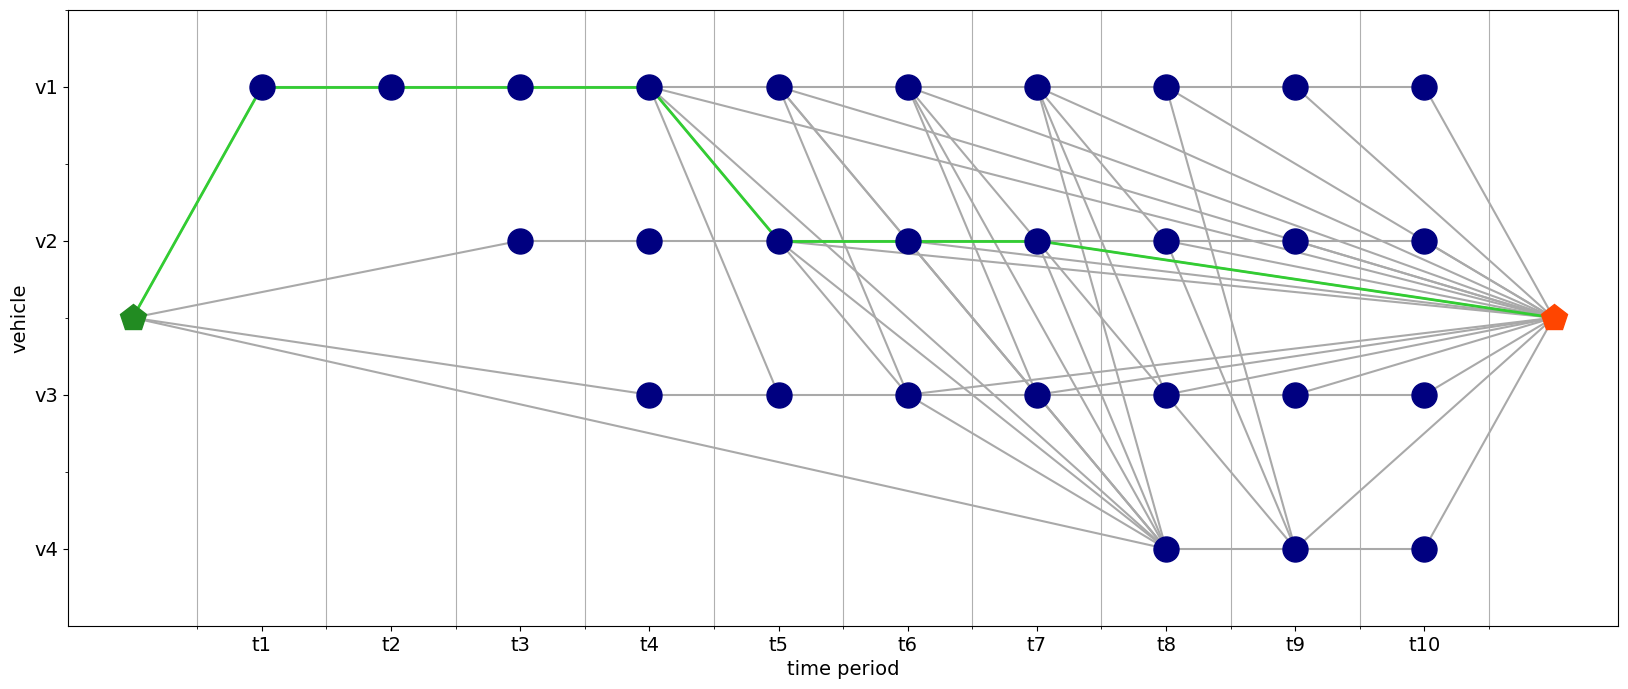

In [10]:
V,A,rc = get_graph(1,C,T,a,k,d,p,cd,cw,{f"V{c}":0 for c in C},0)
Route = [(2.5,0),(1,1),(1,2),(1,3),(1,4),(2,5),(2,6),(2,7),(2.5,11)]
plot_graph(1,V,A,C,T,a,k,Route=Route)

In [7]:
''' Number of vehicles and stations '''

C = list(range(1,101))
S = list(range(1,11))

''' Fixed parameters '''

driving_speed = 75 # miles per hour
steps_per_hour = 6 # each time step is ten minutes
charging_speed = 75*12/7 # miles per hour
T = list(range(1,int(steps_per_hour*2.5)+1)) # Planning horizon

loc, scale, min_v, max_v= 100, 50, 20, 250
a, b = (min_v - loc) / scale, (max_v - loc) / scale

''' Feasible instance generator '''

d = distance_matrix(vehicles,stations)

random.seed(453)
''' Feasible instance creation '''
feas_long = 145; feas_lat = 75

stations = stations[(stations[0] >= feas_long) & (stations[1] <= feas_lat)]
stations.index = np.arange(1, len(stations) + 1)
indices = random.sample(range(len(stations)), len(S))
stations = stations.iloc[indices]
stations.index = np.arange(1, len(stations) + 1)

vehicles = vehicles[(vehicles[0] >= feas_long) & (vehicles[1] <= feas_lat)]
vehicles.index = np.arange(1, len(vehicles) + 1)

feasible = 0; sample_vehic = pd.DataFrame({0:[], 1:[], "range":[]})
while feasible < len(C):
    index = random.randint(1,vehicles.shape[0]-1)
    range_real = truncnorm.rvs(a = a, b = b, loc = loc, scale = scale, size = 1)

    if feasibility_vehic_to_locations(vehicles, index, range_real, stations, steps_per_hour, driving_speed, charging_speed, T) >= len(S):
        feasible += 1
        sample_vehic = pd.concat([sample_vehic,pd.DataFrame({0:vehicles.loc[index,0], 1:vehicles.loc[index,1], "range":[range_real]},index=[0])])
        sample_vehic.index = np.arange(1, len(sample_vehic) + 1)

d = distance_matrix(sample_vehic,stations)
r = {c:sample_vehic.loc[c,"range"][0] for c in C}
p = {(c,s):250-(r[c]-d[c,s]) for c in C for s in S}
a = {(c,s):int(d[c,s]*steps_per_hour/driving_speed)+1 for c in C for s in S}
k = {(c,s):int(p[c,s]*steps_per_hour/charging_speed)+1 for c in C for s in S}
y = {s:6 for s in S}
cf = 5500
cd = 0.041
cw = 0.0388

In [8]:
def chorizo_maker(S,C,S_c,C_s,T,cd,cw,d,p):

    routes = {0:[]}
    for c in C:
        routes[0].append(({cc:1 if cc == c else 0 for cc in C},250*(cd+cw)))

    np.random.seed(0)
    for s in S:
        rand = np.random.choice(C_s[s])
        routes[s] = [({c:1 if c == rand else 0 for c in C_s[s]},cd*d[rand,s]+cw*p[rand,s])]

    return routes

def master_problem(S,C,y,routes,S_c,C_s,output=0,write=0,integer=0):

    R = {s:range(len(routes[s])) for s in S+[0]}

    f_r = {s:{r:routes[s][r][1] for r in R[s]} for s in S+[0]}
    z_r = {s:{r:routes[s][r][0] for r in R[s]} for s in S+[0]}

    m = Model("Restricted Master Problem")

    if integer == 1: nat = GRB.BINARY
    else: nat = GRB.CONTINUOUS

    lbd = {s:{r:m.addVar(name=f"lambda_{s,r}",vtype=nat) for r in R[s]} for s in S+[0]}

    for c in C:
        m.addConstr(quicksum(z_r[s][r][c]*lbd[s][r] for s in S_c[c]+[0] for r in R[s]) >= 1, f"V{c}_assignment")

    for s in S:
        m.addConstr(quicksum(lbd[s][r] for r in R[s]) <= y[s], f"S{s}_convexity")
    
    m.setObjective(quicksum(f_r[s][r]*lbd[s][r] for s in S+[0] for r in R[s]))

    m.update()
    m.setParam("OutputFlag",output)
    m.optimize()

    z = {(c,s):sum(z_r[s][r][c]*lbd[s][r].X for r in R[s]) for s in S for c in C_s[s]}
    infeasible = [c for c in C if sum(z_r[0][r][c]*lbd[0][r].X for r in R[0]) > 0]

    pi_0 = {}
    if integer == 0:
        for c in C:
            cons = m.getConstrByName(f"V{c}_assignment")
            pi_0[f"V{c}"] = cons.getAttr("Pi")
        for s in S:
            cons = m.getConstrByName(f"S{s}_convexity")
            pi_0[f"S{s}"] = cons.getAttr("Pi")
    
    if write:
        A = m.getA()
        denseMatrix = pd.DataFrame(data=csr_matrix.todense(A))
        denseMatrix.to_csv("./Amatrix_MP.csv", index=False)

    return pi_0,infeasible,m.getObjective().getValue(),z

def second_stage_SPP(S,C,T,y,a,d,r,p,k,cd,cw):

    def feas(v,s):
        return d[v,s]<=r[v] and a[v,s]+k[v,s]-1<=T[-1] and a[v,s]<=T[-1]
    
    optimal = False; i = 0

    S_c = {c:[s for s in S if feas(c,s)] for c in C}
    C_s = {s:[c for c in C if feas(c,s)] for s in S}
    routes = chorizo_maker(S,C,S_c,C_s,T,cd,cw,d,p)

    objs = []; exist = len(routes[1])
    time0 = time()

    while not optimal:
        i += 1

        pi, infeasible, objMP,zz = master_problem(S,C,y,routes,S_c,C_s,output=0)
        print(f"Iteration {i}:\n{len(infeasible)} vehicles\tMP obj: {round(objMP,2)}\ttime: {round(time()-time0,2)}s")

        opt = {}
        for s in S:
            V,A,rc = get_graph(s,C_s[s],T,a,k,d,p,cd,cw,pi,pi[f"S{s}"])
            ext = vertices_extensions(V,A)
            opt[s] = label_algorithm(s,V,A,C_s[s],T,rc,k,a,ext,pi,pi[f"S{s}"])
            print(f"Station {s}: {len(opt[s])} new columns")
            routes[s] += opt[s]

        if sum(len(opt[s]) for s in S) == 0: optimal = True
        else: objs.append(objMP)
    
    pi, infeasible, objMP, zz = master_problem(S,C,y,routes,S_c,C_s,output=0,integer=1)

    return infeasible, objMP, zz, objs

In [14]:
infeasibleSPP1, objMP1, zz1, objs1 = second_stage_SPP(S,C,T,y,a,d,r,p,k,cd,cw)

Iteration 1:
91 vehicles	MP obj: 1872.03	time: 0.08s
Station 1: 746 new columns
Station 2: 7868 new columns
Station 3: 2908 new columns
Station 4: 4514 new columns
Station 5: 8995 new columns
Station 6: 5906 new columns
Station 7: 7540 new columns
Station 8: 4896 new columns
Station 9: 8318 new columns
Station 10: 4549 new columns
Iteration 2:
0 vehicles	MP obj: 463.06	time: 1909.67s
Station 1: 0 new columns
Station 2: 0 new columns
Station 3: 0 new columns
Station 4: 0 new columns
Station 5: 0 new columns
Station 6: 0 new columns
Station 7: 0 new columns
Station 8: 0 new columns
Station 9: 0 new columns
Station 10: 0 new columns


In [12]:
objMP1, infeasibleSPP1

(463.058162921771, [])

In [14]:
infeasibleSPP, objMP, zz, objs = second_stage_SPP(S,C,T,y,a,d,r,p,k,cd,cw)

Iteration 1:
46 vehicles	MP obj: 943.11	time: 0.03s
Station 1: 776 new columns
Station 2: 1283 new columns
Station 3: 1243 new columns
Station 4: 293 new columns
Iteration 2:
3 vehicles	MP obj: 330.95	time: 62.09s
Station 1: 0 new columns
Station 2: 0 new columns
Station 3: 0 new columns
Station 4: 0 new columns


In [15]:
stations, infeasible, obj_cochino, df_vehic = scheduling(y,C,S,T,p,k,a,r,d,cd,cw,sample_vehic,FIFO=1,output=1)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6538 rows, 5228 columns and 76490 nonzeros
Model fingerprint: 0xfa2df776
Variable types: 3981 continuous, 1247 integer (1247 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 997.5000000
Presolve removed 566 rows and 945 columns
Presolve time: 0.71s
Presolved: 5972 rows, 4283 columns, 63241 nonzeros
Variable types: 2858 continuous, 1425 integer (1425 binary)
Found heuristic solution: objective 979.3629351

Root relaxation: objective 2.995347e+02, 1971 iterations, 0.21 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth